
|       | Ile 1 | Ile 2 | Ile 3 | Ile 4 |
|-------|-------|-------|-------|-------|
| **Ile 1** | 0     | 0.3   | 0.3   | 0.4   |
| **Ile 2** | 0.3   | 0     | 0.4   | 0.3   |
| **Ile 3** | 0.3   | 0.4   | 0     | 0.3   |
| **Ile 4** | 0.4   | 0.3   | 0.3   | 0     |

In [35]:
# diviser la poputions en sous populations (5 pour les 5 opérateurs de mutation => 1 opérateur par ile)
# migrations d'une ile a l'autre géré par des probabilités
# matrice de transition pour stocker les probabilités de migration
# graphe de transition des iles complet (chaque ile est reliée à toutes les autres)
# a chaque migration, on récupère le feedback de la fitness de l'individu migré et on met à jour la matrice de transition
# 𝑀(𝑡+1) = 𝑓(𝑀 𝑡 ) => f est une fonction de mise à jour de la matrice de transition
# variables du problème :
# • Ensemble d’iles 𝐼 = {𝑖1,…, 𝑖𝑛}
# • Ensemble d’opérateurs/algos A = {𝑎1,…, 𝑎𝑛}, 𝑎𝑘 
# affecté à 𝑖𝑘
# • Ensemble de populations P = {𝑝1,…, 𝑝𝑛}
# • Topologie 𝐼, 𝑉 (ici graphe complet)
# • Matrice de migration 𝑀 de taille 𝑛 × 𝑛, 𝑀 𝑖, 𝑗 ∈ 0,1
# • Politique de migration Π: 𝐼 × 𝑀 → 𝐼

# fonction f de learing de la matrice de transition
# 𝑀(𝑡+1) = 1 − 𝛽 𝛼𝑀 𝑡 𝑖, 𝑘 + 1 − 𝛼 𝑅 t k + 𝛽𝑁 𝑡 (𝑘)
# 𝛽𝑁 𝑡 (𝑘) bruit de migration (permet la diversification)
# 1 − 𝛼 𝑅 t k  R => récompense de la migration alpha est le taux d'apprentissage
# 𝛼𝑀 𝑡 𝑖, 𝑘 + 1 − 𝛼 𝑅 t k meme stratégie de mis a jour que pour les Q-Learning
# 𝛼𝑀 𝑡 𝑖, 𝑘 + 1 − 𝛼 𝑅 t k  partie réenforcement
# # fonction de récompense :
# 𝐸𝑙𝑖𝑡𝑖𝑠𝑡 𝑅𝑖
# 𝑡 𝑘 =
# 1 / |𝐵| 𝑖𝑓 𝑘 ∈ 𝐵𝑒𝑠𝑡 sinon
# 0

# pseudo code de l'algorithme
# Initialize population;
# repeat
# foreach population do
# foreach individual do
# One local search iteration;
# Update the Transition Matrix T;
# Migration Process;
# until stop condition;
# Algorithm : Generic Dynamic Island Model (DIM)

# he crucial point concerns the update of the transition
# matrix T , which follows a learning process:
# Tt = (1 − β)(α.Tt−1 + (1 − α).Rt) + β.Nt

# For an easier representation, we identify each island
# by an ordinal; for example, ({1, . . . , N }, {1, . . . , N }2)
# represents the topology of a N -islands model.
# Migration policies are given by a transition (stochas-
# tic) matrix T of size n, where T (i, j) represents the
# probability for an individual to migrate from island i to
# island j (or to stay at the same island if i = j). Since
# the model is dynamic, T can be updated before of after
# each migration process. One can denote Tt the matrix
# at time (or generation) t

# reward function
# Rt(i, j) =
# {
# 1/|B| if j ∈ B,
# 0 otherwise,
# with B = argmax
# j′
# ∑
# x∈Mij′t acc(x)
# |Mij′t|

# la reward se caclul sur l'ameliortion de la fitness de l'individu migré. on calcul l'amelioration moyenne pour chaque ile ou on a envoyé des individu.
# on partage la reward entre les iles qui ont reçu des individus qui ont amélioré la meilleur amelioraiton moyenne.
# B : meilleur ile => | B | nombre des meilleurs ile, ils devront partager la reward


In [36]:
# # Algorithme : Modèle d'Îles Dynamiques Générique (DIM)
# # Initialisation
# Initialiser les populations P = {p1, p2, ..., pn}
# Initialiser la matrice de transition T avec des probabilités initiales
# Initialiser α, β, et définir N(t)(k) pour chaque île k
# 
# 
# # Fonction de calcul de l'amélioration moyenne
# Fonction calculerAmeliorationMoyenne(j, x):
#     somme_fitness = somme(fitness des individus migrés vers j qui ont amélioré)
#     nombre = nombre d'individus migrés vers j qui ont amélioré
#     si nombre > 0 alors
#         retourner somme_fitness / nombre
#     sinon
#         retourner 0
#     fin si
# FinFonction

TAILLE_VECTEUR = 1000
TAILLE_POPULATION = 20
MAX_ITER = 30000
N = 4
import random

def mutation1flip(individu):
    individu.bits[random.randint(0, TAILLE_VECTEUR - 1)] = 1 - individu.bits[random.randint(0, TAILLE_VECTEUR - 1)]
    return individu

def mutation3flip(individu):
    for i in range(3):
        individu.bits[random.randint(0, TAILLE_VECTEUR - 1)] = 1 - individu.bits[random.randint(0, TAILLE_VECTEUR - 1)]
    return individu

def mutation5flip(individu):
    for i in range(5):
        individu.bits[random.randint(0, TAILLE_VECTEUR - 1)] = 1 - individu.bits[random.randint(0, TAILLE_VECTEUR - 1)]
    return individu

def mutationBitFlip(individu):
    # 1/N chance de muter pour chaque bit
    for i in range(TAILLE_VECTEUR):
        if random.random() < 1/TAILLE_VECTEUR:
            individu.bits[i] = 1 - individu.bits[i]
    return individu



--- Iteration 0 ---
Migration from Ile 1-flip (ID:0) to Ile 5-flip (ID:2)
Migration from Ile 1-flip (ID:0) to Ile 3-flip (ID:1)
Migration from Ile 1-flip (ID:0) to Ile BitFlip (ID:3)
Migration from Ile 1-flip (ID:0) to Ile 5-flip (ID:2)
Migration from Ile 1-flip (ID:0) to Ile 5-flip (ID:2)
Migration from Ile 1-flip (ID:0) to Ile 3-flip (ID:1)
Migration from Ile 1-flip (ID:0) to Ile BitFlip (ID:3)
Migration from Ile 1-flip (ID:0) to Ile BitFlip (ID:3)
Migration from Ile 1-flip (ID:0) to Ile 3-flip (ID:1)
Migration from Ile 1-flip (ID:0) to Ile 3-flip (ID:1)
Migration from Ile 1-flip (ID:0) to Ile 5-flip (ID:2)
Migration from Ile 1-flip (ID:0) to Ile 3-flip (ID:1)
Migration from Ile 1-flip (ID:0) to Ile BitFlip (ID:3)
Migration from Ile 1-flip (ID:0) to Ile 5-flip (ID:2)
Migration from Ile 1-flip (ID:0) to Ile 5-flip (ID:2)
Migration from Ile 1-flip (ID:0) to Ile 5-flip (ID:2)
Migration from Ile 1-flip (ID:0) to Ile BitFlip (ID:3)
Migration from Ile 1-flip (ID:0) to Ile BitFlip (ID:3)
M

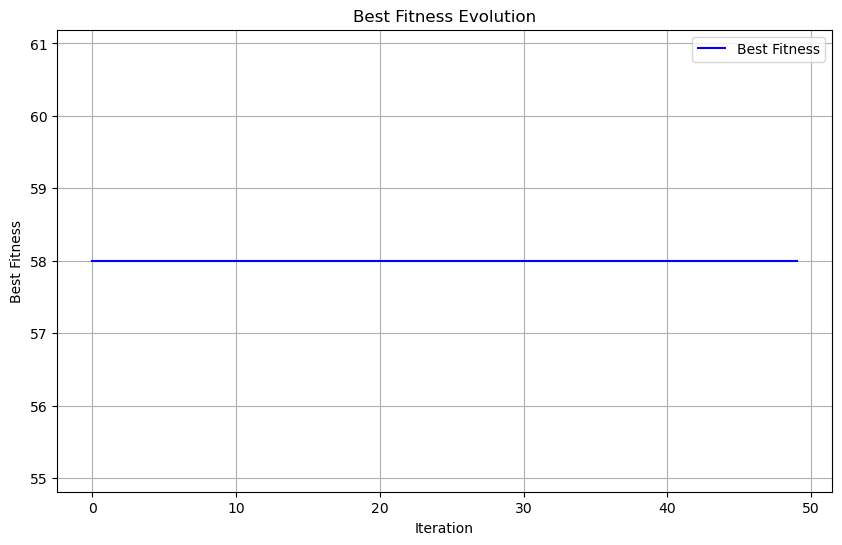

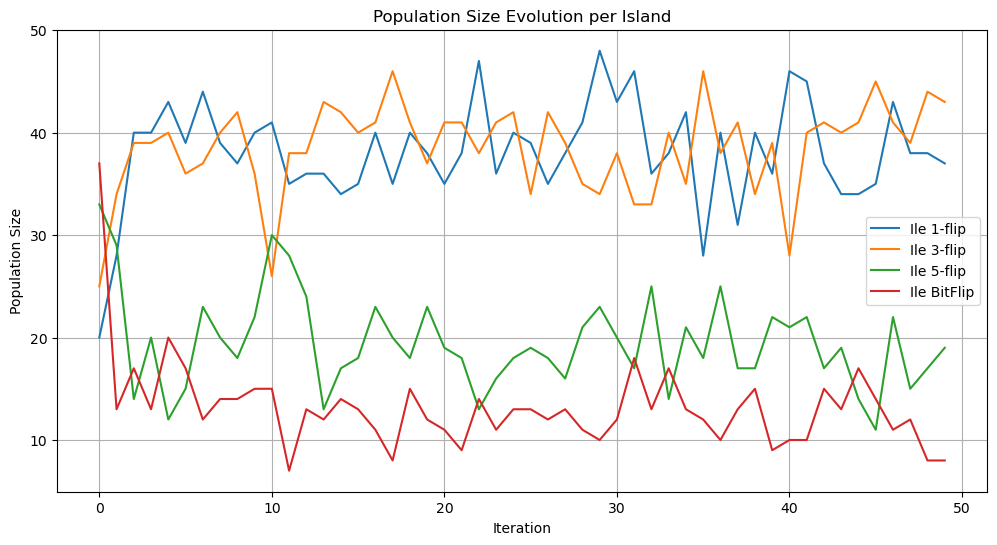

In [37]:
class Individu:
    def __init__(self):
        self.bits = [0 for i in range(TAILLE_VECTEUR)]
        self.origin = None
        self.currentIsland = None
        self.upgrate = 0
    
    def getFitness(self):
        return sum(self.bits)
    
class Island:
    def __init__(self, id, operator,name):
        self.id = id
        self.population = [Individu() for i in range(TAILLE_POPULATION)]
        self.operator = operator
        self.name = name
        
    def getBestElement(self):
        return max(self.population, key=lambda x: x.getFitness())
    
    def getBestFitness(self):
        return self.getBestElement().getFitness()
    
class Archipelo:
    def __init__(self):
        self.islands = [
            Island(0, mutation1flip, "Ile 1flip"),
            Island(1, mutation3flip, "Ile 3flip"),
            Island(2, mutation5flip, "Ile 5flip"),
            Island(3, mutationBitFlip, "Ile BitFlip")
        ]
        self.migrationMatrix = [[1/N for i in range(N)] for j in range(N)]
        self.rewardMatrix = [[0.0 for i in range(N)] for j in range(N)]
        self.bestFitness = 0
        self.bestIsland = None
        self.alpha = 0.1
        self.beta = 0.1
        self.noise = 0.1
        
    def getBestElement(self):
        return max(self.islands, key=lambda x: x.getBestElement().getFitness())
    
    def getBestFitness(self):
        return self.getBestElement().getBestFitness()
    
    def updateMigrationMatrix(self):
        for i in range(N):
            for j in range(N):
                self.migrationMatrix[i][j] = (1 - self.beta) * (self.alpha * self.migrationMatrix[i][j] + (1 - self.alpha) * self.rewardMatrix[i][j]) + self.beta * self.noise
    
    def updateRewardMatrix(self):
        # Réinitialiser la matrice de récompense
        self.rewardMatrix = [[0.0 for i in range(N)] for j in range(N)]
        
        # Pour chaque île source
        for source_island in self.islands:
            # Récupérer la population qui a migré de cette île
            migrants = []
            for dest_island in self.islands:
                if dest_island != source_island:
                    migrants += [ind for ind in dest_island.population if ind.origin == source_island.id]
            
            # Séparer les migrants selon leur currentIsland
            migrantsByDestination = {}
            for dest_island in self.islands:
                migrantsByDestination[dest_island] = [ind for ind in migrants if ind.currentIsland == dest_island.id]
            
            # Calculer l'amélioration moyenne pour chaque île
            ameliorations = {}
            for dest_island in self.islands:  
                if len(migrantsByDestination[dest_island]) > 0:
                    ameliorations[dest_island] = sum([ind.upgrate for ind in migrantsByDestination[dest_island]]) / len(migrantsByDestination[dest_island])
                else:
                    ameliorations[dest_island] = 0
            
            # Déterminer les meilleures îles
            max_ameliore = max(ameliorations.values())
            bestIslands = [i for i in self.islands if ameliorations[i] == max_ameliore]
          
            # Partager la récompense entre les meilleures îles
            if bestIslands:
                reward_per_best = 1.0 / len(bestIslands)  # Récompense égale pour chaque meilleure île
                for best in bestIslands:
                    self.rewardMatrix[source_island.id][best.id] += reward_per_best
                    
    def applyMutation(self):
        for island in self.islands:
            for ind in island.population:
                fitness_before = ind.getFitness()
                island.operator(ind)
                fitness_after = ind.getFitness()
                ind.upgrate = fitness_after - fitness_before

    def migration(self):
        for source_island in self.islands:
            destinations = list(range(N)) 
            probabilities = self.migrationMatrix[source_island.id]
            # Itérer sur une copie de la population pour éviter les problèmes de modification de liste
            for ind in source_island.population[:]:
                destination = random.choices(destinations, weights=probabilities, k=1)[0]
                # Mettre à jour les informations de l'individu
                ind.origin = source_island.id
                ind.currentIsland = destination
                
                # Effectuer la migration
                source_island.population.remove(ind)
                self.islands[destination].population.append(ind)
    
    

                        
    